In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lag, avg, dayofmonth, month, year, date_format,dayofweek,
    monotonically_increasing_id
)
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
from pyspark.sql import SparkSession
# Tạo Spark session + bật Hive
spark = SparkSession.builder \
    .appName("CryptoTrainAllCoins_Optimized") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .config("spark.sql.shuffle.partitions", "8")\
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
# 2. Đọc dữ liệu thô từ Hive
df_raw = spark.sql("SELECT Date, Open, High, Low, Close, Volume, coin FROM crypto_db.crypto_prices")

In [4]:
# 3. Tạo dimension tables (dim_coin, dim_date)
dim_coin = df_raw.select("coin").distinct() \
    .withColumn("coin_id", monotonically_increasing_id())
dim_coin.write.mode("overwrite").saveAsTable("crypto_db.dim_coin")

dim_date = df_raw.select("Date").distinct() \
    .withColumn("date_id", date_format("Date", "yyyyMMdd").cast("int")) \
    .withColumn("day", dayofmonth("Date")) \
    .withColumn("month", month("Date")) \
    .withColumn("year", year("Date")) \
    .withColumn("weekday", date_format("Date", "E")) \
    .withColumn("is_weekend", ((dayofweek("Date") == 1) | (dayofweek("Date") == 7)).cast("boolean"))

In [5]:
# Ghi vào Hive table
dim_date.write \
    .format("parquet") \
    .mode("overwrite") \
    .saveAsTable("crypto_db.dim_date")

In [6]:
# 4. Tính feature & label cho toàn bộ coin
window = Window.partitionBy("coin").orderBy("Date")
df_feat = df_raw.orderBy("coin", "Date")
df_feat = df_feat.withColumn("prev_close", lag("Close", 1).over(window)) \
                 .withColumn("label", (col("Close") > col("prev_close")).cast("int")) \
                 .withColumn("pct_change", ((col("Close") - col("prev_close")) / col("prev_close")) * 100) \
                 .withColumn("ma7", avg("Close").over(window.rowsBetween(-6, 0))) \
                 .withColumn("ma30", avg("Close").over(window.rowsBetween(-29, 0))) \
                 .dropna()

In [7]:
# 5. Join dim_coin để lấy coin_id, tạo date_id
df_joined = df_feat.join(dim_coin, on="coin", how="left") \
                   .join(dim_date.select("Date", "date_id"), on="Date", how="left")



In [8]:
# 6. Tạo fact table & lưu
fact_df = df_joined.select(
    "date_id", "coin_id", "Open", "High", "Low", "Close", "Volume",
    "pct_change", "ma7", "ma30", "label"
)
fact_df.write.partitionBy("coin_id").mode("overwrite").saveAsTable("crypto_db.fact_crypto_price")
fact_df.show(20)  # Hiển thị 20 dòng đầu tiên


+--------+-------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+-------------------+-------------------+-----+
| date_id|coin_id|               Open|               High|                Low|              Close|  Volume|         pct_change|                ma7|               ma30|label|
+--------+-------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+-------------------+-------------------+-----+
|20211121|     67| 0.2990280091762543| 0.3323259949684143|0.27083298563957214|  0.293969988822937|666013.0|-1.6789933455869162| 0.2964800000190735| 0.2964800000190735|    0|
|20211122|     67|0.29424700140953064| 0.3332839906215668|0.25044599175453186| 0.2847540080547333|620981.0|-3.1350073540175805| 0.2925713360309601| 0.2925713360309601|    0|
|20211123|     67|0.28477799892425537|0.28861498832702637|0.20972900092601776| 0.2461860030889511|642836.0|-13.544323828575896|0.2

In [9]:
# 7. ML Pipeline
assembler = VectorAssembler(
    inputCols=["Open", "High", "Low", "Volume", "pct_change", "ma7", "ma30"],
    outputCol="features"
)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
pipeline = Pipeline(stages=[assembler, rf])

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

coin_ids = [2, 1, 21, 9, 11, 12, 22, 6, 17, 23]

results_rf = []
results_gbt = []

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

for cid in coin_ids:
    print(f"\n========== TRAIN CHO COIN ID {cid} ==========")
    coin_data = fact_df.filter(col("coin_id") == cid).orderBy("date_id")
    total = coin_data.count()
    if total < 100:
        print(f"[WARN] Coin {cid} chỉ có {total} record, bỏ qua.")
        continue

    w = Window.orderBy("date_id")
    coin_data = coin_data.withColumn("row_num", row_number().over(w))

    train_cnt = int(total * 0.8)
    train_df = coin_data.filter(col("row_num") <= train_cnt)
    test_df = coin_data.filter(col("row_num") > train_cnt)

    if train_df.count() == 0 or test_df.count() == 0:
        print(f"[ERROR] Train/Test rỗng cho Coin {cid}, bỏ qua.")
        continue

    label_dist = train_df.groupBy("label").count().collect()
    if len(label_dist) < 2:
        print(f"[SKIP] Coin {cid} chỉ có 1 nhãn trong train set, bỏ qua.")
        continue

    assembler = VectorAssembler(
        inputCols=["Open", "High", "Low", "Volume", "pct_change", "ma7", "ma30"],
        outputCol="features"
    )
    train_vec = assembler.transform(train_df)
    test_vec = assembler.transform(test_df)

    # Random Forest
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10, seed=42)
    rf_model = rf.fit(train_vec)
    rf_preds = rf_model.transform(test_vec)
    rf_f1 = evaluator_f1.evaluate(rf_preds)
    rf_acc = evaluator_acc.evaluate(rf_preds)
    results_rf.append((cid, rf_f1, rf_acc))

    print(f"[RF|Coin {cid}] F1 = {rf_f1:.4f}, Acc = {rf_acc:.4f}")

    # rf_preds.select("date_id", "coin_id", "label", "prediction") \
    #     .write.mode("overwrite") \
    #     .saveAsTable(f"crypto_db.predictions_rf_coin_{cid}")

    # GBT
    gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50, maxDepth=10, seed=42)
    gbt_model = gbt.fit(train_vec)
    gbt_preds = gbt_model.transform(test_vec)
    gbt_f1 = evaluator_f1.evaluate(gbt_preds)
    gbt_acc = evaluator_acc.evaluate(gbt_preds)
    results_gbt.append((cid, gbt_f1, gbt_acc))

    print(f"[GBT|Coin {cid}] F1 = {gbt_f1:.4f}, Acc = {gbt_acc:.4f}")

    # gbt_preds.select("date_id", "coin_id", "label", "prediction") \
    #     .write.mode("overwrite") \
    #     .saveAsTable(f"crypto_db.predictions_gbt_coin_{cid}")

print("\n=== TỔNG KẾT KẾT QUẢ RANDOM FOREST ===")
for (cid, f1, acc) in results_rf:
    print(f"Coin {cid} => F1: {f1:.4f}, Acc: {acc:.4f}")

print("\n=== TỔNG KẾT KẾT QUẢ GBT ===")
for (cid, f1, acc) in results_gbt:
    print(f"Coin {cid} => F1: {f1:.4f}, Acc: {acc:.4f}")



========== TRAIN CHO COIN ID 2 ==========
[RF|Coin 2] F1 = 0.9974, Acc = 0.9974
[GBT|Coin 2] F1 = 0.9974, Acc = 0.9974

========== TRAIN CHO COIN ID 1 ==========
[RF|Coin 1] F1 = 0.9961, Acc = 0.9961
[GBT|Coin 1] F1 = 0.9961, Acc = 0.9961

========== TRAIN CHO COIN ID 21 ==========
[RF|Coin 21] F1 = 0.9981, Acc = 0.9981
[GBT|Coin 21] F1 = 0.9981, Acc = 0.9981

========== TRAIN CHO COIN ID 9 ==========
[RF|Coin 9] F1 = 0.9981, Acc = 0.9981
[GBT|Coin 9] F1 = 0.9740, Acc = 0.9740

========== TRAIN CHO COIN ID 11 ==========
[RF|Coin 11] F1 = 0.9963, Acc = 0.9963
[GBT|Coin 11] F1 = 0.9944, Acc = 0.9944

========== TRAIN CHO COIN ID 12 ==========
[RF|Coin 12] F1 = 0.9889, Acc = 0.9888
[GBT|Coin 12] F1 = 0.9703, Acc = 0.9703

========== TRAIN CHO COIN ID 22 ==========
[RF|Coin 22] F1 = 0.9889, Acc = 0.9888
[GBT|Coin 22] F1 = 0.9814, Acc = 0.9814

========== TRAIN CHO COIN ID 6 ==========
[RF|Coin 6] F1 = 0.9870, Acc = 0.9870
[GBT|Coin 6] F1 = 0.9851, Acc = 0.9851

========== TRAIN CHO COIN I

In [11]:
from pyspark.sql import SparkSession

# Khởi tạo SparkSession nếu cần
spark = SparkSession.builder.getOrCreate()

print("\n=== BẢNG SO SÁNH KẾT QUẢ GIỮA RANDOM FOREST VÀ GBT ===")
comparison_data = []
rf_better_f1 = 0
gbt_better_f1 = 0
rf_better_acc = 0
gbt_better_acc = 0

for i in range(len(results_rf)):
    cid = results_rf[i][0]
    rf_f1, rf_acc = results_rf[i][1], results_rf[i][2]
    gbt_f1, gbt_acc = results_gbt[i][1], results_gbt[i][2]

    f1_winner = "RF" if rf_f1 > gbt_f1 else "GBT" if gbt_f1 > rf_f1 else "Tie"
    acc_winner = "RF" if rf_acc > gbt_acc else "GBT" if gbt_acc > rf_acc else "Tie"

    if f1_winner == "RF": rf_better_f1 += 1
    elif f1_winner == "GBT": gbt_better_f1 += 1

    if acc_winner == "RF": rf_better_acc += 1
    elif acc_winner == "GBT": gbt_better_acc += 1

    comparison_data.append((cid, rf_f1, gbt_f1, f1_winner, rf_acc, gbt_acc, acc_winner))

# Tạo DataFrame để in đẹp hơn
comparison_df = spark.createDataFrame(comparison_data, [
    "Coin ID", "RF F1", "GBT F1", "F1 Better Model", "RF Acc", "GBT Acc", "Acc Better Model"
])

comparison_df.show(truncate=False)

print(f"\nSố coin RF thắng GBT về F1: {rf_better_f1}")
print(f"Số coin GBT thắng RF về F1: {gbt_better_f1}")
print(f"Số coin RF thắng GBT về Accuracy: {rf_better_acc}")
print(f"Số coin GBT thắng RF về Accuracy: {gbt_better_acc}")



=== BẢNG SO SÁNH KẾT QUẢ GIỮA RANDOM FOREST VÀ GBT ===
+-------+------------------+------------------+---------------+------------------+------------------+----------------+
|Coin ID|RF F1             |GBT F1            |F1 Better Model|RF Acc            |GBT Acc           |Acc Better Model|
+-------+------------------+------------------+---------------+------------------+------------------+----------------+
|2      |0.9973920914430652|0.9973920914430652|Tie            |0.9973924380704041|0.9973924380704041|Tie             |
|1      |0.9960886969979328|0.9960886969979328|Tie            |0.9960886571056062|0.9960886571056062|Tie             |
|21     |0.9981411030494383|0.9981411030494383|Tie            |0.9981412639405205|0.9981412639405205|Tie             |
|9      |0.9981412960520275|0.9739582540430338|RF             |0.9981412639405205|0.9739776951672863|RF              |
|11     |0.9962827334223842|0.9944239652572584|RF             |0.9962825278810409|0.9944237918215614|RF        

In [22]:
comparison_df.show()


+-------+------------------+------------------+---------------+------------------+------------------+----------------+
|Coin ID|             RF F1|            GBT F1|F1 Better Model|            RF Acc|           GBT Acc|Acc Better Model|
+-------+------------------+------------------+---------------+------------------+------------------+----------------+
|      2|0.9973920914430652|0.9973920914430652|            Tie|0.9973924380704041|0.9973924380704041|             Tie|
|      1|0.9960886969979328|0.9960886969979328|            Tie|0.9960886571056062|0.9960886571056062|             Tie|
|     21|0.9981411030494383|0.9981411030494383|            Tie|0.9981412639405205|0.9981412639405205|             Tie|
|      9|0.9981412960520275|0.9739582540430338|             RF|0.9981412639405205|0.9739776951672863|              RF|
|     11|0.9962827334223842|0.9944239652572584|             RF|0.9962825278810409|0.9944237918215614|              RF|
|     12|0.9888572678141889|0.9703357289338708| 

In [21]:
!ls comparison_rf_gbt.csv


ls: cannot access 'comparison_rf_gbt.csv': No such file or directory


<AxesSubplot:xlabel='Coin ID'>

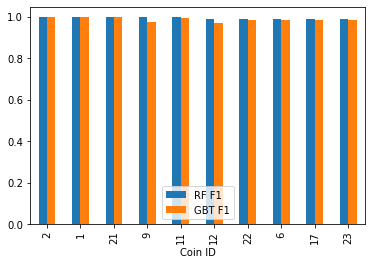

In [13]:
comparison_df_pd = comparison_df.toPandas()
comparison_df_pd.plot.bar(x="Coin ID", y=["RF F1", "GBT F1"])


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec_df = VectorAssembler(inputCols=["Open", "High", "Low", "Volume", "pct_change", "ma7", "ma30"], outputCol="features")\
    .transform(fact_df.dropna())

correlation_matrix = Correlation.corr(vec_df, "features").head()[0]
print("Correlation matrix:\n", correlation_matrix.toArray())


Correlation matrix:
 [[ 1.00000000e+00  9.99097754e-01  9.99652848e-01  7.79208187e-03
  -3.82963507e-04  9.99462376e-01  9.95892197e-01]
 [ 9.99097754e-01  1.00000000e+00  9.98819409e-01  7.82839986e-03
   2.24966299e-03  9.98686494e-01  9.95063860e-01]
 [ 9.99652848e-01  9.98819409e-01  1.00000000e+00  7.72067235e-03
  -3.82513637e-04  9.99140026e-01  9.95463303e-01]
 [ 7.79208187e-03  7.82839986e-03  7.72067235e-03  1.00000000e+00
  -2.44135373e-05  7.79233872e-03  7.70254770e-03]
 [-3.82963507e-04  2.24966299e-03 -3.82513637e-04 -2.44135373e-05
   1.00000000e+00 -1.25769628e-05 -2.96093326e-04]
 [ 9.99462376e-01  9.98686494e-01  9.99140026e-01  7.79233872e-03
  -1.25769628e-05  1.00000000e+00  9.97166445e-01]
 [ 9.95892197e-01  9.95063860e-01  9.95463303e-01  7.70254770e-03
  -2.96093326e-04  9.97166445e-01  1.00000000e+00]]


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


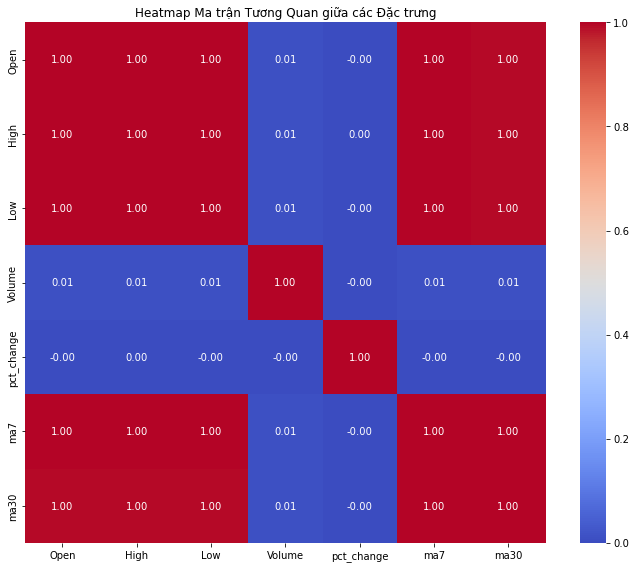

+--------+-------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+-------------------+-------------------+-----+
| date_id|coin_id|               Open|               High|                Low|              Close|  Volume|         pct_change|                ma7|               ma30|label|
+--------+-------+-------------------+-------------------+-------------------+-------------------+--------+-------------------+-------------------+-------------------+-----+
|20211121|     67| 0.2990280091762543| 0.3323259949684143|0.27083298563957214|  0.293969988822937|666013.0|-1.6789933455869162| 0.2964800000190735| 0.2964800000190735|    0|
|20211122|     67|0.29424700140953064| 0.3332839906215668|0.25044599175453186| 0.2847540080547333|620981.0|-3.1350073540175805| 0.2925713360309601| 0.2925713360309601|    0|
|20211123|     67|0.28477799892425537|0.28861498832702637|0.20972900092601776| 0.2461860030889511|642836.0|-13.544323828575896|0.2

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Tên các cột
feature_cols = ["Open", "High", "Low", "Volume", "pct_change", "ma7", "ma30"]

# Lấy ma trận tương quan dưới dạng array
corr_array = correlation_matrix.toArray()

# Tạo DataFrame Pandas cho đẹp
corr_df = pd.DataFrame(corr_array, columns=feature_cols, index=feature_cols)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap Ma trận Tương Quan giữa các Đặc trưng")
plt.tight_layout()
plt.show()


In [18]:

spark.sql("SHOW TABLES IN crypto_db").show(truncate=False)


+---------+-------------------+-----------+
|namespace|tableName          |isTemporary|
+---------+-------------------+-----------+
|crypto_db|crypto_prices      |false      |
|crypto_db|dim_coin           |false      |
|crypto_db|dim_date           |false      |
|crypto_db|fact_crypto_price  |false      |
|crypto_db|predictions_coin_0 |false      |
|crypto_db|predictions_coin_1 |false      |
|crypto_db|predictions_coin_11|false      |
|crypto_db|predictions_coin_12|false      |
|crypto_db|predictions_coin_17|false      |
|crypto_db|predictions_coin_2 |false      |
|crypto_db|predictions_coin_21|false      |
|crypto_db|predictions_coin_22|false      |
|crypto_db|predictions_coin_23|false      |
|crypto_db|predictions_coin_6 |false      |
|crypto_db|predictions_coin_9 |false      |
+---------+-------------------+-----------+



In [110]:
spark.sql("""
    SELECT * 
    FROM crypto_db.fact_crypto_price
""").show()


+--------+------------------+------------------+------------------+------------------+-----------+--------------------+------------------+------------------+-----+-------+
| date_id|              Open|              High|               Low|             Close|     Volume|          pct_change|               ma7|              ma30|label|coin_id|
+--------+------------------+------------------+------------------+------------------+-----------+--------------------+------------------+------------------+-----+-------+
|20140918| 456.8599853515625| 456.8599853515625|   413.10400390625|424.44000244140625|  3.44832E7|  -7.192557601231182| 440.8870086669922| 440.8870086669922|    0|      1|
|20140919| 424.1029968261719| 427.8349914550781| 384.5320129394531| 394.7959899902344|  3.79197E7|   -6.98426450868382|425.52333577473956|425.52333577473956|    0|      1|
|20140920| 394.6730041503906| 423.2959899902344|389.88299560546875|408.90399169921875|  3.68636E7|   3.573491642945347| 421.3684997558594| 4